# Exploration: Principal Component Analysis (PCA) and Receiver Operating Characteristic (ROC)

A fundamental component of mastering data science concepts is applying and practicing them. This exploratory notebook is designed to provide you with a semi-directed space to do just that with the Python, PCA, machine learning-based (ML-based) classification, and visualization skills that you either covered in an in-person workshop or through Microsoft Learn. The specific examples in this notebook apply Python and pandas concepts in a life-sciences context, but they are equally applicable across other disciplines and industry verticals.

This notebook is divided into different stages of exploration. Initial suggestions for exploration are more structured than later ones and can provide some additional concepts and skills for tackling data-science challenges with real-world data. However, this notebook is designed to provide you with a launchpad for your personal experimentation with data science, so feel free to add cells and run your own experiments beyond those suggested here. That is the power and the purpose of a platform like Jupyter Notebook!

## Setup and Refresher on Notebooks

Before we begin, you will need to import the principal libraries used to explore and manipulate data in Python: NumPy, pandas, and scikit-learn. The cell below also imports Matplotlib, the main visualization library in Python. For simplicity and consistency with prior instructions, industry-standard aliases are applied to these imported libraries. The cell below also runs the `%matplotlib inline` magic command, which instructs Jupyter to display Matplotlib output directly in the notebook. This cell also imports many of the specific functions from scikit-learn that you will need, but feel free to import others as you see fit in the course of your exploration.

In [1]:
import pandas as pd
import numpy as np
from itertools import cycle
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

As it might have been a while since you last worked with Jupyter notebooks, here is a quick refresher on efficiently using them.

### Notebook Cells

Notebook cells are divided into Markdown text cells and interactive code cells. You can easily recognize code cells by the `[-]:` to the left of them.

Code in a code cells has only been executed -- and is thus available for use in other code cells in the notebook -- if there is a number beside the code cell (for example, `[1]:`).

To run the code in a cell, you can click the **Run** icon at the top left of a code cell or press **`Ctrl` + `Enter`**.

### Instructor's Note

Open-ended questions for students and groups in this notebook are followed by italicized explanations in your copy of this notebook to more easily help you guide group discussions or answer student questions.

### Documentation and Help

Documentation for Python objects and functions is available directly in Jupyter notebooks. In order to access the documentation, simply put a question mark in front of the object or function in a code cell and execute the cell (for example, `?print`). A window containing the documentation will then open at the bottom of the notebook.

## Scenario

In this workshop, you will step into the role of a data scientist at a biotech firm. Specifically, you are tasked with making sense of experimental genetic data. The dataset is sparse and high-dimensional (64 observations across 3,116 features), so you will need to rely on principal component analysis (PCA) to conduct your initial examination of the data. Furthermore, your management is interested in both which features contribute to susceptibility to liver toxicity and which features contribute to insensitivity to it. Because multiple classes (sensitivity and insensitivity) will be involved in your classifications, you will also want to evaluate the performance of your initial ML investigation agaist each class (rather than just overall).

##  Dataset

The dataset that you have been asked to investigate comes from a liver toxicity study (Bushel *et al.*, 2007) in which 64 male rats were exposed to non-toxic (50 or 150 mg/kg), moderately toxic (1500 mg/kg), or severely toxic (2000 mg/kg) doses of acetaminophen (the active ingredient in Tylenol) in a controlled experiment. Necropsies were performed at 6, 18, 24, and 48 hours after exposure, and the mRNA from the liver was extracted. Ten clinical chemistry measurements of variables containing markers for liver injury are available for each subject, and the serum enzymes levels are measured numerically. (See the [dataset description](https://www.rdocumentation.org/packages/mixOmics/versions/6.3.2/topics/liver.toxicity) for more details.)

The data were further normalized and pre-processed by Bushel *et al.* (2007) and are available to you in four files:
 - **gene.csv**: The expression measure of 3116 genes for the 64 subjects (rats)
 - **clinic.csv**: The 10 clinical variables for the same 64 subjects
 - **treatment.csv**: The treatment information on the 64 subjects, such as doses of acetaminophen and times of necropsies
 - **gene.ID**: GeneBank IDs and gene titles of the annotated genes

### Reference
Bushel, P., Wolfinger, R. D. and Gibson, G. (2007). Simultaneous clustering of gene expression data with clinical chemistry and pathological evaluations reveals phenotypic prototypes. *BMC Systems Biology* **1**, Number 15.

## Section 1: Guided Exploration

The first task in any data role is easy: import the data into a DataFrame and quickly look over it to see what you are dealing with.

In [2]:
# Import the data from genes.csv into a DataFrame.
genes = pd.read_csv('Data/gene.csv')
genes.head()

,Unnamed: 0,A_43_P14555,A_43_P22290,A_43_P20792,A_43_P21286,A_43_P12995,A_43_P15834,A_43_P12356,A_42_P564516,A_43_P22018,...,A_43_P13364,A_43_P19192,A_42_P749591,A_43_P18851,A_42_P781006,A_42_P681939,A_42_P494919,A_42_P686985,A_42_P584179,A_42_P720241
0,ID202,0.05169,-0.08120,0.00617,0.00003,0.00676,-0.02205,0.07924,0.09455,0.00545,...,-0.01204,0.11173,-0.00341,-0.03136,-0.04537,-0.01097,0.00456,0.01764,-0.03689,-0.03383
1,ID203,0.01548,0.17515,0.04845,0.04730,0.08869,0.08395,0.13531,0.15532,0.39802,...,0.09816,-0.10411,-0.02896,-0.06875,-0.01966,-0.02134,0.01074,0.00337,-0.03571,-0.07884
2,ID204,-0.01509,-0.04790,-0.02313,-0.02269,-0.07799,-0.02140,-0.03300,-0.02723,-0.08280,...,-0.00906,-0.07492,-0.00693,-0.05736,0.04733,0.02379,0.03079,0.02706,0.01149,0.04517
3,ID206,-0.02654,0.02407,-0.00558,-0.00775,-0.02446,0.01963,0.00638,0.02534,0.00584,...,0.01390,0.17412,0.03480,-0.03606,0.09780,-0.00712,0.04528,0.18034,0.03154,0.00960
4,ID208,0.05005,0.02214,-0.02543,-0.04412,-0.01130,0.01046,0.07629,0.13695,0.06808,...,0.04883,0.45590,0.00415,-0.07667,-0.08998,-0.01053,0.02887,0.07662,0.04669,0.08906


The dataset may only have 64 observations (one for each rat), but each one has 3,116 features (each gene). To fully visualize this dataset requires a 3,116-dimensional space (one dimension per feature/gene), an impossibilty to deal with directly. Looking at just a subset of the features can also be tricky: how will researchers know if they selected the right features? This is why you have been tasked with performing PCA on it: correctly done, PCA can strike a balance of projecting the dataset down into a low-enough dimensional space that visualization is feasible and also preserving necessary information in the process. 

### Run PCA

To begin the process, fit a PCA model for the data and then graph the variance of the PCA components (the `explained_variance_ratio_` attribute of the PCA model), looking for the elbow in that graph (as you did in the Reactors module on PCA). To do so, you will need to create a scikit-learn PCA oject and then use its [`fit_transform()`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA.fit_transform) method. This will fit the model used to performn the dimensionality-reduction transformation on the data.

In [3]:
# Create a PCA object and use its fit_transform() method.
fit = PCA()
pca = fit.fit_transform(genes.iloc[:, 1:])

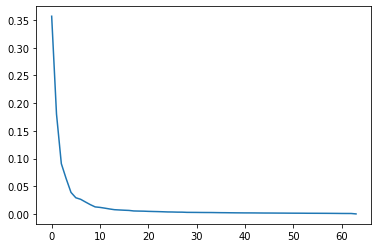

In [4]:
plt.plot(fit.explained_variance_ratio_);

We are looking for the 'elbow' in the graph: the point of inflection at which we start to get far less explained variance for each additional component.

The elbow appears to be at about 4. Check the sum of the variance of the first four PCA components, and then print out the sum and the explained variance.

In [5]:
# Print out the sum of the explained variance of the first four components.
print(fit.explained_variance_ratio_[:4].sum())

0.691441992886173


In [6]:
# Print out the explained variance of the first four components.
print(fit.explained_variance_ratio_[:5])

[0.35684128 0.18027769 0.09069665 0.06362638 0.03885429]


**Group or Partner Discussion**

 - What does this array mean? Why should you care about these numbers and what do they tell you in the context of this liver toxicity dataset?
    - *This array lists the amount of the variance in the dataset encapsulated in each principal component. The first component explains 35.7% of the variance, the second component explains 18% of the variance, and so forth. Put another way, the print-out of the sum of explained variance shows that just the first four components account for nearly 70% of all of the variance--the useful information--in the dataset.*
    - *In the context of the dataset, the array of explained variance numbers means that notwithstanding the extremely high dimensionality of the dataset (3,116 dimensions), we can meaningfully examine this data in dimensions that we can visualize (2 or 3). Put another way, by examing just three components, for example, we can work in a space that we can visualize but that still captures close to 63% of the useful information in the dataset. This will significantly aid us in identifying patterns in the data that can help the researchers identify specific genes for deeper study.*

### Create the PCA DataFrame

As you did in the Reactors PCA module, create a DataFrame from the first four PCA components (the ones that encompass about 70% of your data's variance). You will need this DataFrame in order to begin visually exploring the "flattened" data (that is, of the dataset projected down from 3,116 dimension down to four).

In [7]:
# Create a new DataFrame consisting of the first four components.
pca_df = pd.DataFrame(pca[:, :4], index=genes.index)
pca_df.head()

,0,1,2,3
0,-4.619277,1.256022,0.372496,-1.252229
1,-4.306901,0.429662,0.027401,-0.678449
2,-1.338796,-3.533384,-0.315989,-1.031007
3,-1.754343,-3.998385,-0.791022,-1.469187
4,-3.758652,0.282899,0.366681,-1.646003


For convenience and clarity, rename the columns of the DataFrame 'c1' through 'c4'. (You may find the [`pandas.DataFrame.rename`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html) method helpful for this.)

**Group or Partner Discussion**

 - Review the Reactors PCA module. What do the numbers in this DataFrame represent?
    - *Each column in this DataFrame represent a component or eigenvector of the transformed feature space. The 'principal' in principal component analysis arises from the fact that we use only a small subset of all of eigenvectors for analysis--those eigenvectors that capture the most information about the underlying dataset.*
    - *Note that the DataFrame has 64 rows: each column represents a dimension in the new space created by PCA, and each row is a test subject.*

In [8]:
# Rename the columns of the DataFrame 'c1' through 'c4'.
pca_df.rename(columns={0:'c1', 1:'c2', 2:'c3', 3:'c4'}, inplace=True)
pca_df.head()

,c1,c2,c3,c4
0,-4.619277,1.256022,0.372496,-1.252229
1,-4.306901,0.429662,0.027401,-0.678449
2,-1.338796,-3.533384,-0.315989,-1.031007
3,-1.754343,-3.998385,-0.791022,-1.469187
4,-3.758652,0.282899,0.366681,-1.646003


### Import the treatement data

You currently have the gene data but nothing to predict or classify from it. With just the gene data, we don't actually know anything about the connection between a particular gene signature and the results of treatment. In order to start discovering connections between the genes and the treatment regimens, import the data from `treatment.csv` into a new DataFrame.

In [9]:
# Import the treatment.csv data into a new DataFrame.
treatment = pd.read_csv('Data/treatment.csv')
treatment.head()

,Unnamed: 0,Animal.Number,Treatment.Group,Dose.Group,Time.Group
0,202,202,50 MG/KG6 HR,50,6
1,203,203,50 MG/KG6 HR,50,6
2,204,204,50 MG/KG18 HR,50,18
3,206,206,50 MG/KG18 HR,50,18
4,208,208,50 MG/KG24 HR,50,24


Finally, join the columns of the treatment DataFrame in which we are interested (`Dose.Group` and `Time.Group`) to the PCA DataFrame to prepare for visualization; the other columns are either subject ID numbers or a restatement of treatment dosage and won't help us in our visualization. (That said, changing the DataFrame index to be the test-subject ID number can make the DataFrame easier to read for colleagues and researchers; the [`pandas.DataFrame.set_index`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.set_index.html) method can help with that.)

In [10]:
# Join the Dose.Group and Time.Group columns to your PCA DataFrame.
# You can also make your DataFrame more usable to colleagues by making the DataFrame index the test-subject ID number.
pca_df = pca_df.join(treatment.iloc[:, 3:])
pca_df = pca_df.set_index(genes.iloc[:, 0])
del pca_df.index.name
pca_df.head()

,c1,c2,c3,c4,Dose.Group,Time.Group
ID202,-4.619277,1.256022,0.372496,-1.252229,50,6
ID203,-4.306901,0.429662,0.027401,-0.678449,50,6
ID204,-1.338796,-3.533384,-0.315989,-1.031007,50,18
ID206,-1.754343,-3.998385,-0.791022,-1.469187,50,18
ID208,-3.758652,0.282899,0.366681,-1.646003,50,24


## Section 2: Intermediate Exploration

It is now time to begin the meaningful part of PCA: looking for patterns in the lower-dimensional projection of the data. To do this, you will need to create a visualization.

In previous workshops, we have looked at scatterplots as an important means of visualizing multivariate numeric data, which is exactly what your PCA eigenvectors are. Being your visual inspection of the reduced data by creating a 2D scatterplot of the first two columns of your PCA DataFrame (these should correspond with $c_{1}$ and $c_{2}$, which together account for over half of the variance in the dataset). Add some context to the graph by making the colors for the points on the scatterplot correspond to the dosage received by the test subjects (the rats); doing so will help you see patterns within the data.

This [tutorial](https://pythonspot.com/3d-scatterplot/) on creating 3D scatterplots can be adapted for creating your 2D scatterplot. You might also find the `matplotlib.pyplot.scatter` [documentation](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.scatter.html#matplotlib.pyplot.scatter) helpful.

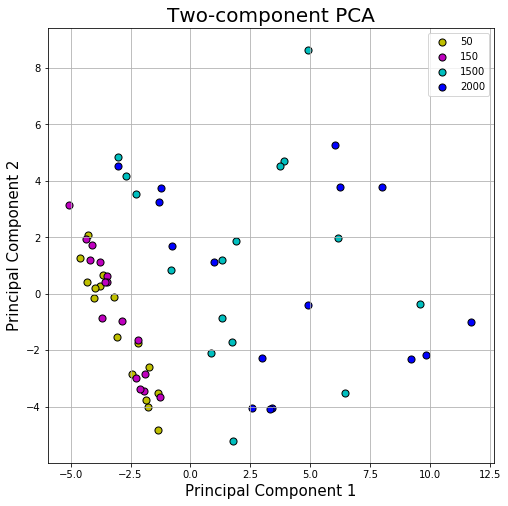

In [11]:
# Create a scatterplot of the first two components, color-coded by dosage.

# Set size for the figure (in inches).
fig = plt.figure(figsize = (8,8))

# Add and label axes for the visualization.
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)

# Add a title to the visualization.
ax.set_title('Two-component PCA', fontsize = 20)

# Create a list of the distinct dosages in the DataFrame.
doses = pca_df['Dose.Group'].unique().tolist()

# Define four colors (one for each dosage).
colors = ['y', 'm', 'c', 'b']

# Use zip to iterate over the dosages (and associated colors).
for dose, color in zip(doses, colors):
    
    # For each dosage, graph only those components with the associated dosage.
    indices_to_show = pca_df['Dose.Group'] == dose

    # Plot the components colored by dosage.
    ax.scatter(pca_df.loc[indices_to_show, 'c1'], 
               pca_df.loc[indices_to_show, 'c2'], 
               edgecolor='k', 
               c=color, 
               s=50)

# Add a legend to aid readability.
ax.legend(doses)

# Add gridlines to aid readability.
ax.grid()

The purpose of this scatterplot is to help us assess whether there are any patterns in the data in just the first two components--which there are! The 50-mg and 150-mg dosages form a nice cluster with a very distinct gap between it and the looser cluster of higher dosages. This would indicate that there are genes that correlate to lethal liver toxicity at lower dosages of acetaminophen.

Does this same patten hold for the time until death? To see whether it does, create the same kind of scatterplot as the last one, this time letting the colors encode the amount of time until necropsies of the subjects were conducted.

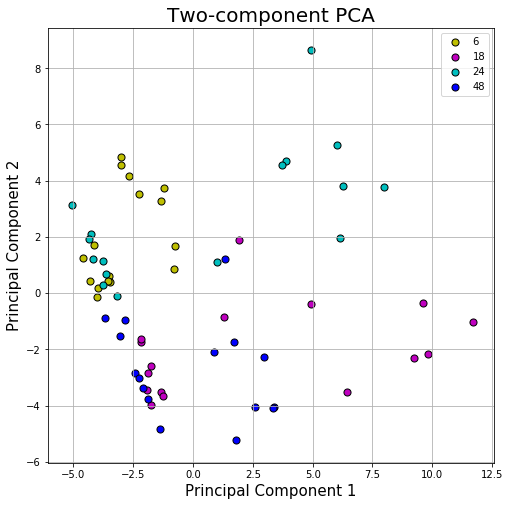

In [12]:
# Create a scatterplot of the first two components, color-coded by time until necropsy.

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Two-component PCA', fontsize = 20)

# Different from the last visualization: create a list of the distinct times.
times = pca_df['Time.Group'].unique().tolist()
colors = ['y', 'm', 'c', 'b']

# Iterate over the times instead of dosages.
for time, color in zip(times, colors):
    indices_to_show = pca_df['Time.Group'] == time
    ax.scatter(pca_df.loc[indices_to_show, 'c1'], 
               pca_df.loc[indices_to_show, 'c2'], 
               edgecolor='k', 
               c=color, 
               s=50)

# Add a legend based on times.
ax.legend(times)
ax.grid()

**Group or Partner Discussion**

 - Did it surprise you that the scatterplots for dosage and time are the same, except with the dots having different colors? Why should this be the case?
    - *The two scatterplots draw their points from the same source--the first two columns of the PCA DataFrame--so they should look the same. That said, similar dosages did not result in identical times until death for the rats, which is why the points have different colors between the two scatterplots.*
 - Did the addition of color-coding for dosage or time to necropsy 'add back' any of the variance in the dataset lost by projecting it down into two dimensions? If not, did the color-coding nevertheless add useful information to the plot? If so, what information did you gain from the addition of the color-coding?
    - *Because we have not added another column (dimension) from the PCA DataFrame, we are not restoring any of the variance to the genes dataset lost in projecting the data down into two dimensions. That said, seeing encoded data for dosage and time provides additional information external to the original dataset that can help us identify patterns in the data.*

Now let's consider the visualization in three dimensions. Alter your scatterplot code now, and also incorporate the third column from the PCA DataFrame (`c3`). You can color-code for either dosage or time, although dosage might present a clearer picture. (You might find the `mpl_toolkits.mplot3d.axes3d.Axes3D` [documentation](https://matplotlib.org/3.2.1/api/_as_gen/mpl_toolkits.mplot3d.axes3d.Axes3D.html) to be helpful.)

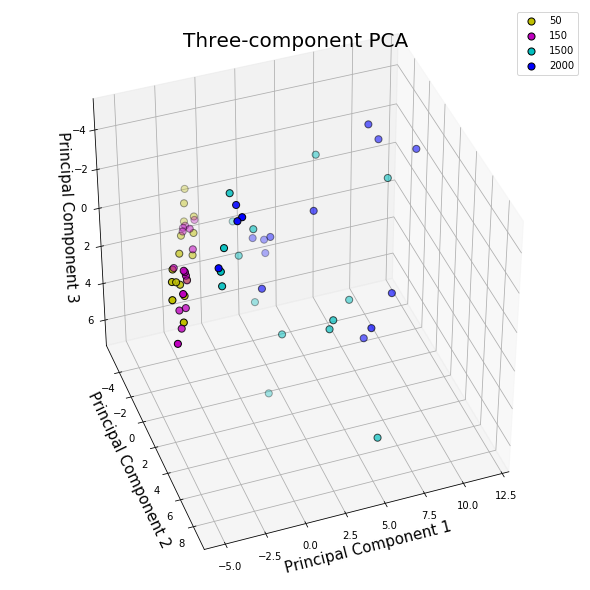

In [13]:
# Create a 3D scatterplot of the first three components color-coded by dosage.

fig = plt.figure(figsize = (8,8))

# Use the Axes3D function instead of the add_subplot method.
ax = Axes3D(fig, elev=-140, azim=290)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('Three-component PCA', fontsize = 20)

# Create a list of the distinct dosages in the DataFrame.
doses = pca_df['Dose.Group'].unique().tolist()
colors = ['y', 'm', 'c', 'b']
for dose, color in zip(doses, colors):
    indices_to_show = pca_df['Dose.Group'] == dose
    ax.scatter(pca_df.loc[indices_to_show, 'c1'], 
               pca_df.loc[indices_to_show, 'c2'], 
               pca_df.loc[indices_to_show, 'c3'], 
               edgecolor='k', 
               c=color, 
               s=50)

# These final items are the same as the previous 2D scatterplots.
ax.legend(doses)
ax.grid()

**Note:** Try a variety of settings for the `elev=` and `azim=` parameters in [`Axes3D`](https://matplotlib.org/3.2.1/api/_as_gen/mpl_toolkits.mplot3d.axes3d.Axes3D.html) until you find some that help you see patterns in the data.

**Group or Partner Discussion**

 - What patterns do you see in the data? Although adding $c_{3}$ to the plot raises the total amount of variance from the original dataset up to close to 63%, did doing so help you better discern patterns in the data? If so, how? If not, why not?
    - *There is a distinct separation in the data between the low dosages (50 mg/kg and 150 mg/kg) and the high dosages (1,500 mg/kg and 2,000 mg/kg) that was apparent in the 2D scatterplot and is more apparent here. However, the consituent high and low dosages still appear quite intermingled, and the additional dimension does not add more clarity to that.*

You can also add more information to the plot without adding additional dimensions. For example, alter your 3D plot to keep dosages color-coded, but make the dots different sizes based on the time to necropsy. (Do this by making the value for the `s=` parameter equal to the `Time.Group` column in your PCA DataFrame. Note that the differences in times is not great, which means that you might want to multiply this value by a constant or raise the time values to a power in order to make the sizes in dots more distinct.)

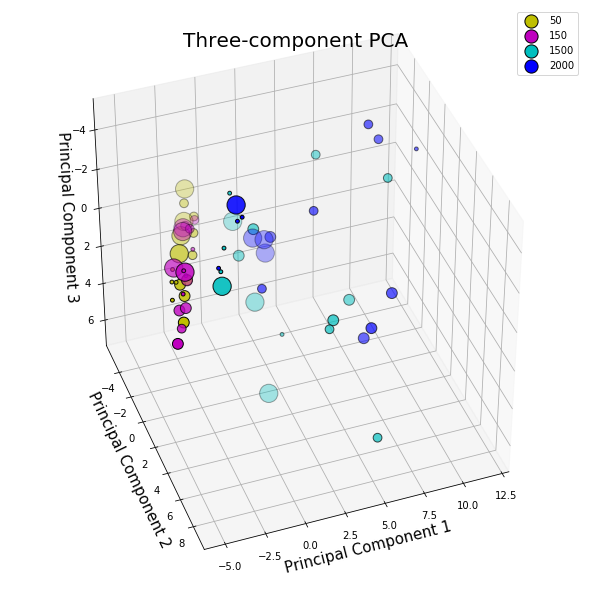

In [14]:
# Create a 3D scatterplot of the first three components color-coded by dosage.
# Make the marker size proportional to time until necropsy.

fig = plt.figure(figsize = (8,8))
ax = Axes3D(fig, elev=-140, azim=290)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('Three-component PCA', fontsize = 20)

doses = pca_df['Dose.Group'].unique().tolist()
colors = ['y', 'm', 'c', 'b']

for dose, color in zip(doses, colors):
    indices_to_show = pca_df['Dose.Group'] == dose
    ax.scatter(pca_df.loc[indices_to_show, 'c1'], 
               pca_df.loc[indices_to_show, 'c2'], 
               pca_df.loc[indices_to_show, 'c3'], 
               edgecolor='k', 
               c=color, 

               # Make marker size equal to time raised to the 1.5 power.
               s=np.power(pca_df['Time.Group'], 1.5))

ax.legend(doses)
ax.grid()

We now have a visualization with five aspects: the three principal components of the dataset, the dosage for the test subjects (the colors of the markers), and the time to necropsy for the subjects (the size of the markers). The now-familiar gap between the cluster of low dosages and the high dosages is still apparent, but adding the time to necropsy does not seem to add much more useful information: no clear patterns among it appear in this plot.

The principal question to ask with all visualizations is: "Does it help my data speak more clearly?" In the case of your role as data investigator, does the third dimension better elucidate patterns in your data? Possibly, possibly not. Let's look at an alternative to a 3D scatterplot: plotting the data across four 2D scatterplots (one for each time value). To do so, return to your 2D scatterplot code and nest your original `for` loop inside another `for` loop that iterates over each of the unique values in the `Time.Group` column in the PCA DataFrame.

(**Note:** You might need to increase the size of the `figsize=` parameter for [`matplotlib.pyplot.figure`](https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.figure.html) in order to clearly see all of the plots.)

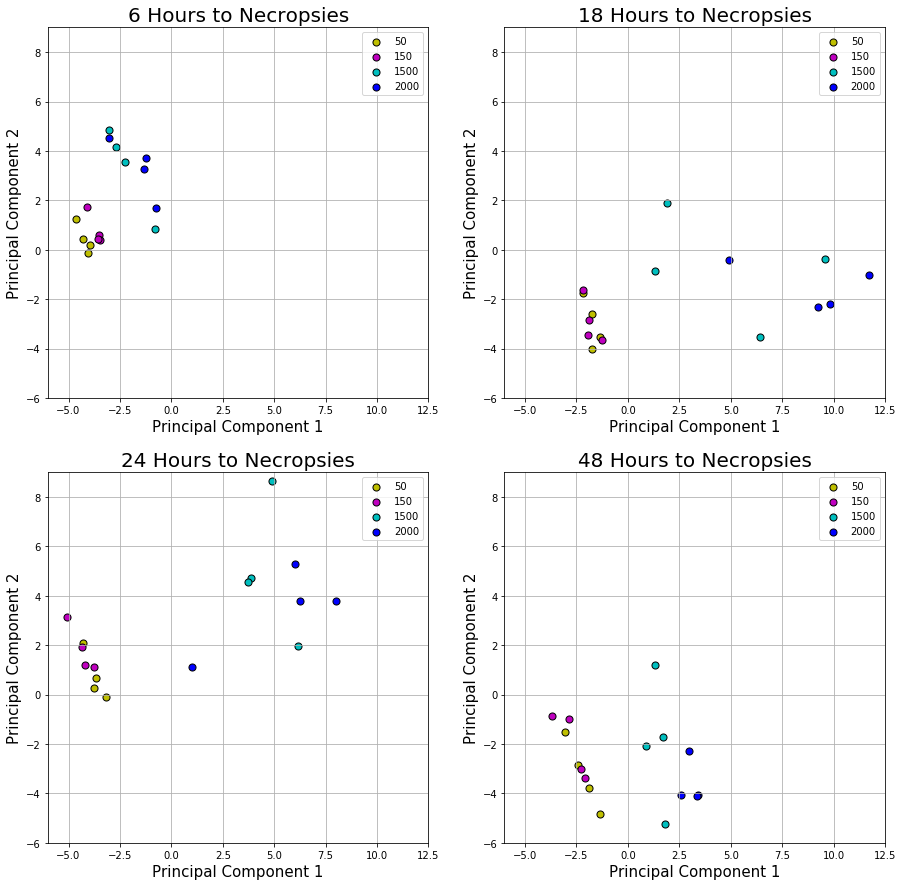

In [15]:
# Create a 2x2 set of scatterplots of the first two components by time and dosage.

fig = plt.figure(figsize = (15, 15))
times = pca_df['Time.Group'].unique().tolist()
doses = pca_df['Dose.Group'].unique().tolist()
colors = ['y', 'm', 'c', 'b']

# Need to loop over times and dosages.
for time in times:
    for dose, color in zip(doses, colors):
        
        # Must use the Python bitwise AND ('&').
        indices_to_show = (pca_df['Dose.Group'] == dose) & (pca_df['Time.Group'] == time)
        index = pca_df['Time.Group'].unique().tolist().index(time)
        ax = fig.add_subplot(2, 2, index + 1) 
        ax.scatter(pca_df.loc[indices_to_show, 'c1']
                , pca_df.loc[indices_to_show, 'c2']
                , edgecolor='k'
                , c=color
                , s=50)
    
    # Explicitly set the axes to match those from the 3D plot to aid with interpretation.
    ax.set(xlim=(-6.0, 12.5), ylim=(-6.0, 9.0))
    ax.set_xlabel('Principal Component 1', fontsize=15)
    ax.set_ylabel('Principal Component 2', fontsize=15)
    ax.set_title(str(time) + ' Hours to Necropsies', fontsize=20)
    ax.legend(doses)
    ax.grid()

Splitting the plot across four subplots let's us clearly see the relationships of dosages between the two principal components for each time group; being plotted in only two dimensions, we do lose information about how these points lie in the third principal component (the z-axis in our previous plots), but that component only accounts for 9% of total variance for the dataset, so we do not lose very much information. The cluster of low dosages is still clearly visible in the lower-left corner of each subplot, but the data points for higher dosages are mingled in each of the subplots, so no additional patterns emerge for those. We may have gleaned about as much information as we can from visualization. 

## Section 3: Individual Exploration

Visual inspection of the data is good, but at some point we want to introduce ML into our investigations. In the Reactors ROC module, you learned about the receiver operating characteristic (ROC) curve as a means to evaluate the performance of ML models. Because the performance of most classification algorithms is a tradeoff between false-positive and false-negative rates, the ROC curve provides a graphical illustration of the ratio of an algorithm's true-positive rate to its false-positive rate. In this section, you will use the ROC curve of a classification model to learn more about the dataset you have been tasked with investigating in your assumed role.

Normally, ROC curves only work for binary models. After all, the curve is the plot of the true positive rate against the false positive rate at various thresholds. However, using the [One versus Rest](https://en.wikipedia.org/wiki/Multiclass_classification) technique, you can use binary classification algorithms for multi-class classification and then plot multiple ROC curves on top of one another.

To do this, adapt this code from the scikit Learn documentation site to work with your liver-toxicity dataset: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#plot-roc-curves-for-the-multilabel-problem

(**Tip:** Classify the data with dosage being your response; use colors for the ROC curves that match the colors you used in your scatterplots to make interpretation easier.)

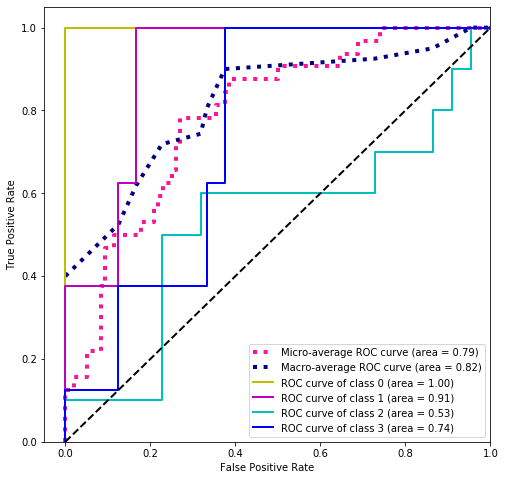

In [16]:
# Select all of the columns except the first from the genes DataFrame for your predictors.
# Select the dosage column of the treatment DataFrame as your response.
X = genes.iloc[:, 1:]
y = treatment.iloc[:, 3]

# Binarize the output.
y = label_binarize(y, classes=[50, 150, 1500, 2000])
n_classes = y.shape[1]

# Shuffle and split training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.5,
                                                    random_state=0)

# Learn to predict each class against each of the others.
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True, random_state=0))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class.
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area.
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First, aggregate all false-positive rates.
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at these points.
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally, average the ROC curves and compute the AUCs.
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot the ROC curves, micro-average, and macro-averages.
plt.figure(figsize = (8, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='Macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

line_width = 2
colors = cycle(['y', 'm', 'c', 'b'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=line_width,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=line_width)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

You ROCs curves should reflect a mixture of superb performance to abysmal output for the classification algorithm. On the good end of the spectrum--class 0, which corresponds to 50 mg dosage group--we have perfect classification: a 100% true positive rate with no false positives. On the other end of the performance spectrum, class 2 (the 1500 mg dosage group) provides several instances in which it supplies more false positives than true ones (any time the ROC curve dips below the diagonal dotted line on the plot).

A related metric shown in this plot is the area under the curve. This is just what it sounds like: a measure of the area of the region bounded by the ROC curve and the bottom of the plot. What does this metric represent? If we look at our perfect classifier (class 0), it has an area under curve (AUC) of 1.00, whereas the rather poor class 2 has an AUC just over 0.50 (representing, on average, a classifier that supplies as many false positives as true ones). A higher AUC is an indicator of better overall classifier performance.

The macro-avarage and micro-average curves are two ways of assessing overall performance of all of the classifiers. The macro-average is a simple average of the performance of each classifier for each false-positive rate; the micro-average is a weighted average of these. See [this response](https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin) on Stack Exchange for a more complete explanation.

**Group or Partner Discussion**

 - What does this range of performance by the classifier tell you about the dataset, if anything?
    - *While visually inspecting the data, we noticed that the 50 and 150 dosage-groups were distinct from the 1500 and 2000 dosage-groups, which is in part borne out by the performance of the classifier. We also noted that the specific dosages within the high- and low-dosage clusters were intermingled, but the performance of the classifier indicates that this was really only the case in the high-dosage cluster. There is some distinct separation between the 50 and 150 dosage-groups at a higher dimension that is not obvious in two or three dimensions (which is why we must always use a variety of tools to investigate our data).*

Note that code you repurposed used a classification algorithm called *support vector machines* (SVMs), which we have not yet addressed in the Reactors modules. Generate the multi-class ROC curves again, but this time use a classification algorithm you are familiar with: logistic regression. Not only is logistic regression a classification algorithm that we have examined before in the Reactors modules, it will lend itself to clearer interpretation when you will be tasked later on with tying results back to individual genes.

In addition, run this with `Time.Group` as the response rather than `Dose.Group`, which will also prove helpful later on.

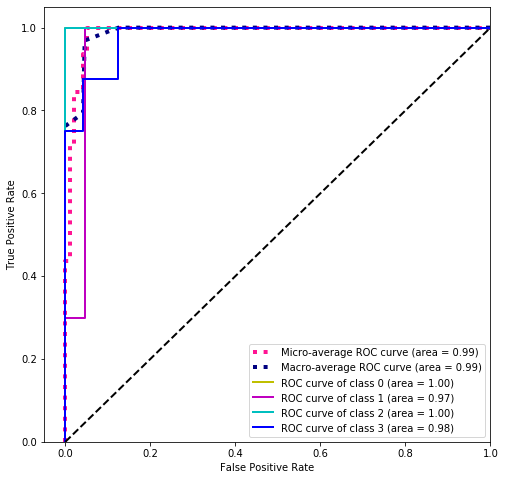

In [17]:
# Same predictors as last time but with Dose.Group for the response.
X = genes.iloc[:, 1:]
y = treatment.iloc[:, 4]

# Binarize the output as before.
y = label_binarize(y, classes=[6, 18, 24, 48])
n_classes = y.shape[1]

# Shuffle and split training and test sets as before.
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.5,
                                                    random_state=0)

# Use logistic regression this time.
classifier = OneVsRestClassifier(LogisticRegression(random_state=0))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class.
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area as before.
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Aggregate all false positive rates as before.
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Interpolate all ROC curves at these points as before.
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Average the ROC curves and compute the AUCs as before.
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot the ROC curves and averages as before.
plt.figure(figsize = (8, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='Macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

line_width = 2
colors = cycle(['y', 'm', 'c', 'b'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=line_width,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=line_width)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

You should notice a substantial improvement to classification performance using logistic regression for all classes. If you are curious, remember that you can check the overall accuracy of your model by using `metrics.accuracy_score` from `sklearn`.

In [18]:
# Use a one-versus-rest logistic-regression classifier.
classifier = OneVsRestClassifier(LogisticRegression(random_state=0))

# Fit the classifier.
classifier.fit(X_train, y_train)

# Generate your predicted results.
y_pred = classifier.predict(X_test)

# Assess the overall accuracy of the classifier.
metrics.accuracy_score(y_test, y_pred)

0.84375

In [19]:
# Use a one-versus-rest SVM classifier.
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True, random_state=0))
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.8125

There are two take-aways from this. First, while logistic regression did provide better performance on its own, it was nowhere near dramatic enough to explain the massive improvements we saw in the ROC curves generated with that classifier; the change in the response from `Dose.Group` to `Time.Group` supplied much of that. (If you look at this with logistic regression on `Dose.Group`, the performance will not be much different than with SVMs.)

Second, different algorithms will perform differently with a different set of predictors and responses. For this reason, you should always use a variety of algorithms to see which will work best with your data **and** the specific questions that you are asking about your data.

So far we've noted that while distinguishing between the 1,500 mg/kg and 2,000 mg/kg dose-groups was problematic, our classifier was quite accurate in distinguishing between the low- and high-dosage groups. We also saw that classifying by time-to-necropsy was quite accurate. With this in mind, it ought to be possible to identify which genes contribute most to rats that die quickly from low doses of acetaminophen and which ones that contribute to rats that die slowly even from high doses.

As a final task for this module, pull some tangible insights from the dataset. To identify those genes, create a new column in the treatment DataFrame that flags whether a dosage is not toxic (at or below 150 mg/kg) or toxic. Use that column to create another column, this one dividing the observations into eight categories (short time to death at non-toxic dosage, short time to death at toxic dosage, etc.). You might find the `numpy.where` function and the `pandas.Series.map` method useful in doing this.

Once you have those eight classes in place, run one-versus-rest logistic regression with those new classes as the response, and create multi-class ROC curves to evaluate the classifier.

In [20]:
# Create a new binary column in the treatment DataFrame for dosages that are and are not toxic.
treatment['Toxic'] = np.where(treatment['Dose.Group'] <= 150, 0, 1)

In [21]:
# Create a list of unique times from the Time.Group column.
time_list = treatment['Time.Group'].unique().tolist()

# Create a dictionary of even numbers for each of these unique times.
# You will use this dictionary as the basis of a new column in the DataFrame.
# This column will help group together rats that died quickly or slowly from toxic and non-toxic dosages.
time_dict = {}
for i in range(len(time_list)):
    time_dict[time_list[i]] = 2 * i
time_dict

{6: 0, 18: 2, 24: 4, 48: 6}

In [22]:
# Create a new DataFrame column that creates these groups of susceptible and resistant rats for each time group.
# Do so by adding the value of the Toxic column to the entries in time_dict for each time.
treatment['Group'] = treatment['Time.Group'].map(time_dict) + treatment['Toxic']
treatment.head()

,Unnamed: 0,Animal.Number,Treatment.Group,Dose.Group,Time.Group,Toxic,Group
0,202,202,50 MG/KG6 HR,50,6,0,0
1,203,203,50 MG/KG6 HR,50,6,0,0
2,204,204,50 MG/KG18 HR,50,18,0,2
3,206,206,50 MG/KG18 HR,50,18,0,2
4,208,208,50 MG/KG24 HR,50,24,0,4


In [23]:
treatment.tail()

,Unnamed: 0,Animal.Number,Treatment.Group,Dose.Group,Time.Group,Toxic,Group
59,518,518,2000MG/K18 HR,2000,18,1,3
60,520,520,2000MG/K24 HR,2000,24,1,5
61,521,521,2000MG/K24 HR,2000,24,1,5
62,522,522,2000MG/K48 HR,2000,48,1,7
63,524,524,2000MG/K48 HR,2000,48,1,7


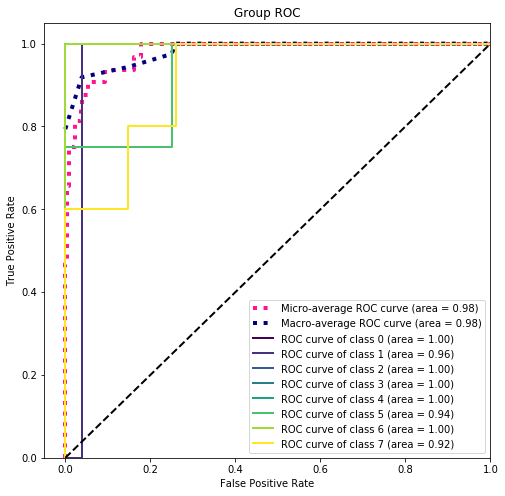

In [24]:
# Use the new Group column as the response for the classifier.
y = treatment.iloc[:, 6]

# Binarize the output as before.
y = label_binarize(y, classes=treatment['Group'].unique().tolist())
n_classes = y.shape[1]

# Shuffle and split training and test sets as before.
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.5,
                                                    random_state=0)

# Use logistic regression as a one-versus-rest classifier as before.
classifier = OneVsRestClassifier(LogisticRegression(random_state=0))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class as before.
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area as before.
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Aggregate all false positive rates as before.
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Interpolate all ROC curves at these points as before.
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Average the ROC curves and compute the AUCs as before.
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot the ROC curves as before.
plt.figure(figsize = (8, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='Macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

line_width = 2

# Specify a color palate rather than specific colors.
colors = plt.cm.viridis(np.linspace(0,1,n_classes))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=line_width,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.title('Group ROC')
plt.plot([0, 1], [0, 1], 'k--', lw=line_width)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

The classification should perform well on the classes of interest to us: the first class (class 0: low-dosage, quick death) and the last class (class 7: high-dosage, slow death).

Identifying the genes most responsible for this behavior requires thinking about the how logistic regression works. Recall that the equation for the logistic regression curve interest is
$$
y = \frac{1}{1 + e^{-(β_0 + β_1X_1 + β_2X_2 + β_3X_3 + \cdots + β_nX_n)}}
$$
where a response less than 0.5 classifies an observation as negative (not in the class in question) and a response greater than 0.5 classifies it as positive (in the class in question) in a binary classification. Because we are dealing with a negative exponent in the denominator of a fraction, positive coefficients (the $β$s) will tend to make an observation get closer to 1 (positive), and negative coefficients will trend it toward 0 (negative). We can thus make the argument that genes with exceptionally large-magnitude positive coefficients carry more weight with classifying an observation into the our desired class.

Your final task is to access the `coef_` attribute for the fitted logistic regression model and print out those genes that correspond to coefficients above an arbitrary threshold (such as 0.15).

In [25]:
# Print out all of the genes whose first coefficient is greater than 0.15.
for i in range(len(classifier.coef_[0])):
    if classifier.coef_[0][i] > 0.15:
        print(X.columns.values.tolist()[i])

A_43_P11903
A_42_P496622
A_43_P13041
A_42_P535877
A_43_P11710


In [26]:
# Print out all of the genes whose last coefficient is greater than 0.15.
for i in range(len(classifier.coef_[7])):
    if classifier.coef_[7][i] > 0.15:
        print(X.columns.values.tolist()[i])

A_43_P12028
A_43_P11285
A_42_P505480


Your printed lists should be rather short. Note that we can't say for certain that these genes specifically grant rats either vulnerability to or protection from liver toxicity due to ingesting acetaminophen. Rather, we have trimmed down the list of possible genes from 3,116 to a handful that scientists can start to investigate in greater detail. But in your assumed role as a data scientist, you have made the research problem for the other scientists on your team a much more manageable one.